the purpose of this book is to make reading medical extracts easy to read



In [ ]:
# !nvidia-smi

# since we are replicating the paper : PubMed 200k RCT , lets download the dataset they have used , we can do it from the authors github


In [ ]:
# !wget https://github.com/Franck-Dernoncourt/pubmed-rct.git

In [ ]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct.git
!ls pubmed-rct

fatal: destination path 'pubmed-rct' already exists and is not an empty directory.
PubMed_200k_RCT
PubMed_200k_RCT_numbers_replaced_with_at_sign
PubMed_20k_RCT
PubMed_20k_RCT_numbers_replaced_with_at_sign
README.md


In [ ]:
#check whats there in this file
!ls /content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign 
#dev is another word for validation set

dev.txt  test.txt  train.txt


In [ ]:
# start our experiment with the 20k dataset 
data_dir="/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/"

In [ ]:
import os
filenames=[data_dir+ filename for filename in os.listdir(data_dir)]
filenames

['/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt']

In [ ]:
#becoming one with the data and preprocessing it

#lets write a function to read in all sentences in the target text file

def get_lines(filename):
  """
  Reads filename (a text file) and returns the lines of text as a list.
  
  Args:
      filename: a string containing the target filepath to read.
  
  Returns:
      A list of strings with one string per line from the target filename.
      For example:
      ["this is the first line of filename",
       "this is the second line of filename",
       "..."]
  """
  with open(filename, "r") as f:
    return f.readlines()

# open the file(filename) in read mode and save it as f
# f.readline reads remaining lines and returns it as a list 



In [ ]:
train_lines=get_lines(data_dir+"train.txt")
train_lines[:25]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

# one way how our data can be represented is by a list of dictionaries
```
eg: [{ 'line_number':0,
       'target':"BACKGROUND",
       'text': "Emotional eating is associated with overeating and the development of obesity .\n'",
       'total_lines':11},
     ...
    }]
```


In [ ]:
def preprocess_text_with_line_numbers(filename):
  ''' 
  returns the list of dictinaries from the abstract line data

  takes in filename, reads its contents and sorts through each line,
  extracting things like the target label , the text of sentence ,how many sentences 
  are in current abstract and what sentences and what sentence number the target line is
  '''
  input_lines= get_lines(filename) #get all lines from filename
  abstract_lines="" #creates an empty abstract
  abstract_samples=[] #creates an empty list of abstracts

  #iterate through each line in input lines
  for line in input_lines:
    if line.startswith("###"):#check to see if the line is id line --> new abstract is starting
      abstract_id=line
      abstract_lines="" #reset the abstract string if the line is id line
    elif line.isspace(): # checks if it is a newline (in python \n is considered as a space )
      abstract_line_split= abstract_lines.splitlines()#split abstract into separate lines 

      #iterate through each line in a single abstract and count them at the same time
      for abstract_line_number,abstract_line in enumerate(abstract_line_split):
        line_data={} #create an empty dictionary for each line
        target_text_split=abstract_line.split("\t") #split target label from text

        #append in the dictionary
        line_data["target"]= target_text_split[0] #get target label
        line_data["text"]=target_text_split[1].lower() #get text 
        line_data["line_number"]=abstract_line_number #what number the line is in the abstract
        line_data["total_lines"]=len(abstract_line_split)-1 #how many total lines are there in the abstract
        abstract_samples.append(line_data)

    else: #if the above conditions are not fulfilled, the line contains a labelled sentence
      abstract_lines +=line

  return abstract_samples





In [ ]:
train_samples=preprocess_text_with_line_numbers(data_dir+"train.txt")
val_samples=preprocess_text_with_line_numbers(data_dir+"dev.txt")
test_samples=preprocess_text_with_line_numbers(data_dir+"test.txt")

len(train_samples),len(val_samples),len(test_samples)

(180040, 30212, 30135)

In [ ]:
train_samples[:10]

[{'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'line_number': 0,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'line_number': 1,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'line_number': 2,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'line_number': 3,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'secondary outcome measures included the western ontari

In [ ]:
import pandas as pd

#turn data into a dataframe to further visualise the data
train_df=pd.DataFrame(train_samples)
val_df=pd.DataFrame(val_samples)
test_df=pd.DataFrame(test_samples)

train_df.head(14)

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11
5,METHODS,"serum levels of interleukin @ ( il-@ ) , il-@ ...",5,11
6,RESULTS,there was a clinically relevant reduction in t...,6,11
7,RESULTS,the mean difference between treatment arms ( @...,7,11
8,RESULTS,"further , there was a clinically relevant redu...",8,11
9,RESULTS,these differences remained significant at @ we...,9,11


In [ ]:
#check the distribution of the labels
train_df.target.value_counts()

METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: target, dtype: int64

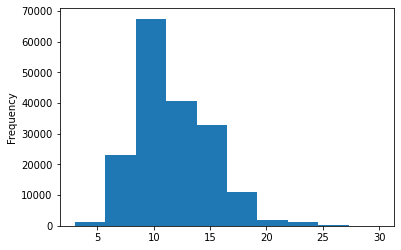

In [ ]:
#lets checck the length of different lines
train_df.total_lines.plot.hist();

In [ ]:
#get list of sentences
train_sentences=train_df["text"].tolist()
val_sentences=val_df["text"].tolist()
test_sentences=test_df["text"].tolist()

len(train_sentences), len(val_sentences), len(test_sentences)

(180040, 30212, 30135)

In [ ]:
#view 10 lines of train sentences
train_sentences[:10]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .',
 'serum levels of interleukin @ ( il-@ ) , il-@ , tumor necrosis factor ( tnf ) - , and high-sensitivity c-reactive protein ( hscrp ) were measured .',
 'there was a clinic

In [ ]:
#one hot our labels
from sklearn.preprocessing import OneHotEncoder
one_hot_encoder=OneHotEncoder(sparse=False) #tensorflow is incompatible with sparse matrix


train_labels_one_hot=one_hot_encoder.fit_transform(train_df["target"].to_numpy().reshape(-1,1))
val_labels_one_hot=one_hot_encoder.transform(val_df["target"].to_numpy().reshape(-1,1))
test_labels_one_hot=one_hot_encoder.transform(test_df["target"].to_numpy().reshape(-1,1))

train_labels_one_hot

array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

In [ ]:
import tensorflow as tf
tf.constant(train_labels_one_hot)


<tf.Tensor: shape=(180040, 5), dtype=float64, numpy=
array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])>

label encode the labels

In [ ]:
#extract labels
from sklearn.preprocessing import LabelEncoder
label_encoder=LabelEncoder()
train_labels_encoded=label_encoder.fit_transform(train_df["target"].to_numpy())
val_labels_encoded=label_encoder.transform(val_df["target"].to_numpy())
test_labels_encoded=label_encoder.transform(test_df["target"].to_numpy())



In [ ]:
train_labels_encoded

array([3, 2, 2, ..., 4, 1, 1])

In [ ]:
# get class names and number of classes from label encoder instance
num_classes=len(label_encoder.classes_)
class_names=label_encoder.classes_
num_classes, class_names

(5, array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

In [ ]:
#model 0: baseline --> tfidf multinomial naive bayes model

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

In [ ]:
#create a pipeline
model_0= Pipeline([
    ("tf-idf",TfidfVectorizer()),
    ("clf",MultinomialNB())

])
#fit pipeline to training data
model_0.fit(X=train_sentences,
            y=train_labels_encoded)

Pipeline(steps=[('tf-idf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [ ]:
#evaluate baseline model on validation set
model_0.score(X=val_sentences,
              y=val_labels_encoded)

0.7218323844829869

In [ ]:
#make predictions using baseline model
baseline_preds=model_0.predict(val_sentences)
baseline_preds

array([4, 1, 3, ..., 4, 4, 1])

In [ ]:
#download helper function script
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2022-12-24 10:35:10--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py.1’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2022-12-24 10:35:10 (109 MB/s) - ‘helper_functions.py.1’ saved [10246/10246]



In [ ]:
from helper_functions  import calculate_results

baseline_results=calculate_results(y_true=val_labels_encoded,
                                   y_pred=baseline_preds)
baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

In [ ]:
# preparing data for deep sequence models


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers

In [ ]:
#how long is one sentence on average?
sent_lens= [len(sentence.split()) for sentence in train_sentences]
avg_sent_len= np.mean(sent_lens)
avg_sent_len

26.338269273494777

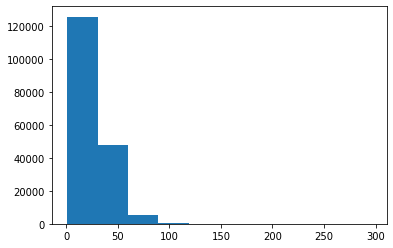

In [ ]:
# what does the distribution looks like?
import matplotlib.pyplot as plt
plt.hist(sent_lens,bins=10);

In [ ]:
# how long of a sentence length will cover 95% of sentences?
output_seq_len=int(np.percentile(sent_lens,95))
output_seq_len

55

In [ ]:
#create text vectorization layer to map tokens to numbers


In [ ]:
# how many words do we have in our vocabulary?
max_tokens= 68000

#create the text vectorizer layer
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
text_vectorizer= TextVectorization(max_tokens=max_tokens,  #number of words in vocabulary
                                   output_sequence_length=55) # output length of vectorized sentences

In [ ]:
# Adapt text vectorizer to training sentences
text_vectorizer.adapt(train_sentences)

In [ ]:
#test text vectorizer on random sentences
import random
target_sentence=random.choice(train_sentences)
print(f"Text : {target_sentence}")
print(f"len of text : {len(target_sentence.split())}")
print(f"Vectorized text : {text_vectorizer([target_sentence])}")

Text : reductions in ppo , mpo and wd were also found between the @st half and @nd half cisp ( p < @ ) and there was a greater decline from the @st half cisp to the @nd half cisp in ppo , mpo and wd at hyp .
len of text : 48
Vectorized text : [[  626     5 15573  7334     3 10479     9   138   208    30     2   933
   1398     3  2748  1398 19020    14     3    61    10     8   182  1078
     27     2   933  1398 19020     6     2  2748  1398 19020     5 15573
   7334     3 10479    15  7209     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]]


In [ ]:
# how many words in our training vocubulary?
rct_20k_vocabulary= text_vectorizer.get_vocabulary()
print(f"total words in vocabulary : {len(rct_20k_vocabulary)}")
print(f"most common words in vocab : {rct_20k_vocabulary[:5]}")
print(f"most uncommon words in vocab : {rct_20k_vocabulary[-5:]}")

total words in vocabulary : 64841
most common words in vocab : ['', '[UNK]', 'the', 'and', 'of']
most uncommon words in vocab : ['aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']


In [ ]:
#get the configuration of text vextorizer
text_vectorizer.get_config()

{'name': 'text_vectorization_1',
 'trainable': True,
 'batch_input_shape': (None,),
 'dtype': 'string',
 'max_tokens': 68000,
 'standardize': 'lower_and_strip_punctuation',
 'split': 'whitespace',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': False,
 'sparse': False,
 'ragged': False,
 'vocabulary': None,
 'idf_weights': None}

In [ ]:
#create custom text embeddings layer
token_embed= layers.Embedding(input_dim=len(rct_20k_vocabulary), #len of vocabulary
                              output_dim=128, #different embedding sizes result in drastically different number of parameters to train in
                              mask_zero=True,
                              name="token_embedding",) 

In [ ]:
# show example embeddings
print(f"Sentence before vectorization: \n {target_sentence}\n")
vectorized_sentence= text_vectorizer([target_sentence])
print(f"sentence after vectorization : {vectorized_sentence}")
embedded_sentence= token_embed(vectorized_sentence)
print(f"Sentence after embedding: {embedded_sentence}\n")
print(f"Embedded sentence shape: {embedded_sentence.shape}")

Sentence before vectorization: 
 reductions in ppo , mpo and wd were also found between the @st half and @nd half cisp ( p < @ ) and there was a greater decline from the @st half cisp to the @nd half cisp in ppo , mpo and wd at hyp .

sentence after vectorization : [[  626     5 15573  7334     3 10479     9   138   208    30     2   933
   1398     3  2748  1398 19020    14     3    61    10     8   182  1078
     27     2   933  1398 19020     6     2  2748  1398 19020     5 15573
   7334     3 10479    15  7209     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]]
Sentence after embedding: [[[ 0.00438046  0.02621717 -0.01756512 ...  0.02877145 -0.04543418
    0.01686894]
  [-0.01870752 -0.03205998  0.03952611 ...  0.04206654  0.01787151
    0.02808661]
  [ 0.04881226 -0.03690992 -0.01421105 ...  0.01005586 -0.0269943
    0.01123518]
  ...
  [-0.01441115  0.04130251 -0.0418056  ...  0.02780409 -0.02701504
   -0.01232737]
  [-0.01441115  0.04130251 -0

In [ ]:
train_labels_one_hot.shape

(180040, 5)

In [ ]:

# creating datasets
# create data pipelines so that our data loads as fast as possible
train_dataset=tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_one_hot))
valid_dataset=tf.data.Dataset.from_tensor_slices((val_sentences, val_labels_one_hot))
test_dataset=tf.data.Dataset.from_tensor_slices((test_sentences, test_labels_one_hot))

train_dataset

<TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

In [ ]:
#take the tensorslice datasets and turns them into prefetched datasets
train_dataset=train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
valid_dataset=valid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset=test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)


In [ ]:
len(train_dataset)

5627

In [ ]:
len(train_dataset)

5627

In [ ]:
num_classes

5

Model 1 : conv1D with token embeddings

In [ ]:
inputs=layers.Input(shape=(1,),dtype=tf.string)
text_vectors= text_vectorizer(inputs) #vectorize text inputs
token_embeddings= token_embed(text_vectors) #CREATE embedding
x= layers.Conv1D(64,kernel_size=5,padding="same",activation="relu")(token_embeddings)
x= layers.GlobalAveragePooling1D()(x)
outputs=layers.Dense(num_classes,activation="softmax")(x)
model_1=tf.keras.Model(inputs,outputs)


In [ ]:
model_1.compile(loss="categorical_crossentropy", optimizer=tf.keras.optimizers.Adam(),metrics=["accuracy"])

In [ ]:
model_1.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 55)               0         
 ectorization)                                                   
                                                                 
 token_embedding (Embedding)  (None, 55, 128)          8299648   
                                                                 
 conv1d (Conv1D)             (None, 55, 64)            41024     
                                                                 
 global_average_pooling1d (G  (None, 64)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense_1 (Dense)             (None, 5)                 325 

In [ ]:
history_model_1=model_1.fit(train_dataset,
                            steps_per_epoch=int(0.1*len(train_dataset)),
                            epochs=3,
                            validation_data=valid_dataset,
                            validation_steps=int(0.1*len(valid_dataset))
                            )

Epoch 1/3
562/562 [==============================] - 14s 9ms/step - loss: 0.9178 - accuracy: 0.6393 - val_loss: 0.6867 - val_accuracy: 0.7364
Epoch 2/3
562/562 [==============================] - 5s 8ms/step - loss: 0.6642 - accuracy: 0.7523 - val_loss: 0.6398 - val_accuracy: 0.7683
Epoch 3/3
562/562 [==============================] - 5s 8ms/step - loss: 0.6221 - accuracy: 0.7736 - val_loss: 0.5991 - val_accuracy: 0.7859


In [ ]:
# evaluate on whole val data set
model_1.evaluate(valid_dataset)

945/945 [==============================] - 3s 3ms/step - loss: 0.6017 - accuracy: 0.7859


[0.6017370223999023, 0.7858797907829285]

In [ ]:
model_1_pred_probs=model_1.predict(valid_dataset)

945/945 [==============================] - 2s 2ms/step


In [ ]:
model_1_pred_probs

array([[4.22758341e-01, 1.69273943e-01, 7.38015398e-02, 3.10025424e-01,
        2.41407100e-02],
       [4.25690353e-01, 3.22864950e-01, 1.17827095e-02, 2.31902719e-01,
        7.75929820e-03],
       [1.83510110e-01, 1.17809540e-02, 3.86094744e-03, 8.00796986e-01,
        5.09601341e-05],
       ...,
       [4.48614855e-06, 6.23843283e-04, 9.18072998e-04, 3.10032442e-06,
        9.98450518e-01],
       [5.79933003e-02, 4.94213730e-01, 8.80445540e-02, 8.31610486e-02,
        2.76587367e-01],
       [1.62183836e-01, 6.49027586e-01, 4.74338084e-02, 4.94463071e-02,
        9.19084996e-02]], dtype=float32)

In [ ]:
# covert predprobs to classes
model_1_preds=tf.argmax(model_1_pred_probs,axis=1)
model_1_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 1, 1])>

In [ ]:
class_names

array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
      dtype=object)

In [ ]:
# calculate model 1 results
model_1.results=calculate_results(y_true=val_labels_encoded,
                                  y_pred=model_1_preds)
model_1.results

{'accuracy': 78.58797828677346,
 'precision': 0.7823122359250607,
 'recall': 0.7858797828677346,
 'f1': 0.7832622347313178}

In [ ]:
baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

In [ ]:
# now lets use pretrained word encoding ie the universal sentence encoder
import tensorflow_hub as hub
tf_hub_embedding_layer=hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                      trainable=False,
                                      name="universal_sentence_encoder")

In [ ]:
#test out the pretrained embedding on a random sentence
random_train_sentence=random.choice(train_sentences)
print(f"random sentence \n{random_train_sentence}")
use_embedded_sentence=tf_hub_embedding_layer([random_train_sentence])
print(f"sentence after embedding : {use_embedded_sentence}")
print(f"length of sentence embedding {len(use_embedded_sentence[0])}")

model 2 : using the tensorflow universal sentence encoder

In [ ]:
inputs=layers.Input(shape=[],dtype=tf.string)

# text_vectors= text_vectorizer(inputs) #vectorize text inputs
# token_embeddings= token_embed(text_vectors) #CREATE embedding
embed=tf_hub_embedding_layer(inputs)
# x= layers.Conv1D(64,kernel_size=5,padding="same",activation="relu")(token_embeddings)
# x= layers.GlobalAveragePooling1D()(x)
x=layers.Dense(128,activation="relu")(embed)
outputs=layers.Dense(num_classes,activation="softmax")(x)
model_2=tf.keras.Model(inputs=inputs,outputs=outputs,name="USE_sentence_encoder")

In [ ]:
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"]
                )

In [ ]:
history_model_2=model_2.fit(train_dataset,
                            epochs=3,
                            steps_per_epoch=int(0.1*len(train_dataset)),
                            validation_data=valid_dataset,
                            validation_steps=int(0.1*len(valid_dataset))
                            )

Epoch 1/3
562/562 [==============================] - 10s 13ms/step - loss: 0.9210 - accuracy: 0.6490 - val_loss: 0.7996 - val_accuracy: 0.6888
Epoch 2/3
562/562 [==============================] - 7s 13ms/step - loss: 0.7719 - accuracy: 0.7013 - val_loss: 0.7580 - val_accuracy: 0.7074
Epoch 3/3
562/562 [==============================] - 7s 13ms/step - loss: 0.7557 - accuracy: 0.7111 - val_loss: 0.7422 - val_accuracy: 0.7118


In [ ]:
model_2.evaluate(valid_dataset)

945/945 [==============================] - 10s 11ms/step - loss: 0.7435 - accuracy: 0.7129


[0.7434799075126648, 0.7128955125808716]

In [ ]:
model_2_pred_probs=model_2.predict(valid_dataset)
model_2_pred_probs

945/945 [==============================] - 9s 10ms/step


array([[4.5719233e-01, 3.4360614e-01, 2.1898285e-03, 1.8807611e-01,
        8.9355158e-03],
       [3.2460442e-01, 5.2374440e-01, 3.0364597e-03, 1.4601764e-01,
        2.5970829e-03],
       [2.4335620e-01, 1.3512307e-01, 1.9900657e-02, 5.6076556e-01,
        4.0854476e-02],
       ...,
       [2.2201363e-03, 5.0020427e-03, 5.2627061e-02, 8.2555477e-04,
        9.3932521e-01],
       [4.1759163e-03, 4.8814271e-02, 2.1766788e-01, 1.3737818e-03,
        7.2796810e-01],
       [2.0165202e-01, 2.5491565e-01, 4.8147705e-01, 6.4807241e-03,
        5.5474587e-02]], dtype=float32)

In [ ]:
model_2_preds=tf.argmax(model_2_pred_probs,axis=1)
model_2_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 3, ..., 4, 4, 2])>

In [ ]:
#calculate results
model_2_results=calculate_results(y_true=val_labels_encoded,
                                  y_pred=model_2_preds)
model_2_results

{'accuracy': 71.2895538196743,
 'precision': 0.7133404319160642,
 'recall': 0.712895538196743,
 'f1': 0.7101971335291826}

In [ ]:
baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

CHARACTER LEVEL EMBEDDINGS

MODEL 3: Conv1D with character level embeddings

In [ ]:
# make function to split sentences into characters
def split_chars(text):
  return " ".join(list(text))

In [ ]:
# " ".join(list(train_sentences[0]))

In [ ]:
split_chars(random_train_sentence)

't h e   s t u d y   p o p u l a t i o n   c o n s i s t s   o f   a l l   p a t i e n t s   a g e d @   y e a r s   o l d   u n d e r g o i n g   p e r c u t a n e o u s   c o r o n a r y   i n t e r v e n t i o n   .'

split sequence-level data splits into character-level splits

In [ ]:
train_chars=[split_chars(sentence) for sentence in train_sentences]
val_chars=[split_chars(sentence) for sentence in val_sentences]
test_chars=[split_chars(sentence) for sentence in test_sentences]


train_chars[:5]

['t o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .',
 'a   t o t a l   o f   @   p a t i e n t s   w i t h   p r i m a r y   k n e e   o a   w e r e   r a n d o m i z e d   @ : @   ;   @   r e c e i v e d   @   m g / d a y   o f   p r e d n i s o l o n e   a n d   @   r e c e i v e d   p l a c e b o   f o r   @   w e e k s   .',
 'o u t c o m e   m e a s u r e s   i n c l u d e d   p a i n   r e d u c t i o n   a n d   i m p r o v e m e n t   i n   f u n c t i o n   s c o r e s   a 

In [ ]:
# whats the avg character length?
char_lens=[len(sentence) for sentence in train_sentences] #gives a list of character level length of every sentence
mean_char_len=np.mean(char_lens) #takes the mean of all the lengths
mean_char_len

149.3662574983337

(array([1.41175e+05, 3.71110e+04, 1.60000e+03, 1.27000e+02, 2.10000e+01,
        5.00000e+00, 1.00000e+00]),
 array([1.00000000e+00, 1.98857143e+02, 3.96714286e+02, 5.94571429e+02,
        7.92428571e+02, 9.90285714e+02, 1.18814286e+03, 1.38600000e+03]),
 <a list of 7 Patch objects>)

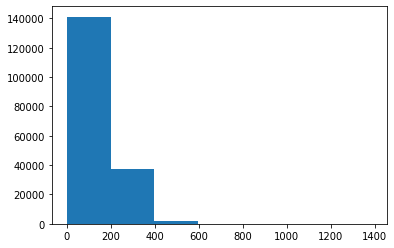

In [ ]:
# check the distribution at character level
import matplotlib.pyplot as plt
plt.hist(char_lens,bins=7)

In [ ]:
# find what character length constitutes to 95% percent of sequences
output_seq_char_len=int(np.percentile(char_lens,95))
output_seq_char_len

290

In [ ]:
# get all keyboard characters
import string
alphabet=string.ascii_lowercase + string.digits + string.punctuation 
alphabet, len(alphabet)

('abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~', 68)

In [ ]:
# create char level vectorizer instance
NUM_CHAR_TOKENS= len(alphabet)+2 # 2 for space and OOV(out of vocab tokens)
char_vectorizer= TextVectorization(max_tokens=NUM_CHAR_TOKENS,
                                   output_sequence_length=output_seq_char_len,
                                   name="char_vectorizer"
                                   )

In [ ]:
# adapt the char vectorizer to training character
char_vectorizer.adapt(train_chars)

In [ ]:
# check char vocab stats
char_vocab=char_vectorizer.get_vocabulary()
print(f"number of different characters in vocab : {len(char_vocab)}")
print(f"most common characters : {char_vocab[:5]}")
print(f"least common characters : {char_vocab[-5:]}")

number of different characters in vocab : 28
most common characters : ['', '[UNK]', 'e', 't', 'i']
least common characters : ['k', 'x', 'z', 'q', 'j']


In [ ]:
# test our character vectorizer
random_train_chars=random.choice(train_chars)
print(f"charified text : {random_train_chars}")
print(f"length of random train chars: {len(random_train_chars.split())}")
vectorized_chars=char_vectorizer([random_train_chars])
print(f"vectorized chars {vectorized_chars}")
print(f"length of vectorized chars : {len(vectorized_chars[0])}")

charified text : e a c h   f i b e r g l a s s   s h o r t   a r m   c a s t   c o n t a i n e d   a n   e m p t y   i n t r a v e n o u s   f l u i d   b a g   i n   w h i c h   w e   i n f u s e d   a i r   .
length of random train chars: 81
vectorized chars [[ 2  5 11 13 17  4 22  2  8 18 12  5  9  9  9 13  7  8  3  5  8 15 11  5
   9  3 11  7  6  3  5  4  6  2 10  5  6  2 15 14  3 19  4  6  3  8  5 21
   2  6  7 16  9 17 12 16  4 10 22  5 18  4  6 20 13  4 11 13 20  2  4  6
  17 16  9  2 10  5  4  8  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0

In [ ]:
#creating character level embedding
char_embed=layers.Embedding(input_dim=len(char_vocab),
                            output_dim=25,
                            mask_zero=True,
                            name= "char_embed")

In [ ]:
# test out character embedding layer
print(f"charified text : {random_train_chars}")
char_embed_example=char_embed(char_vectorizer([random_train_chars]))
print(f"after vectorization and embedding : {char_embed_example}")
print(f"char embedding shape : {char_embed_example.shape}")

charified text : e a c h   f i b e r g l a s s   s h o r t   a r m   c a s t   c o n t a i n e d   a n   e m p t y   i n t r a v e n o u s   f l u i d   b a g   i n   w h i c h   w e   i n f u s e d   a i r   .
after vectorization and embedding : [[[-0.00411249 -0.03406148  0.0440121  ...  0.00686081  0.04423528
   -0.02620119]
  [-0.03247808 -0.03890587 -0.00036422 ... -0.03816622 -0.02193552
    0.04716671]
  [ 0.02805645 -0.018607    0.02940496 ... -0.04737682 -0.01336356
    0.04291615]
  ...
  [-0.02854084  0.00828496  0.03509578 ... -0.00233863 -0.00549876
   -0.04491014]
  [-0.02854084  0.00828496  0.03509578 ... -0.00233863 -0.00549876
   -0.04491014]
  [-0.02854084  0.00828496  0.03509578 ... -0.00233863 -0.00549876
   -0.04491014]]]
char embedding shape : (1, 290, 25)


model 3 : charcter level embeddings

In [ ]:
inputs=layers.Input(shape=(1,),dtype=tf.string)
#vectorizer
vector=char_vectorizer(inputs)
#embed
embed=char_embed(vector)
x= layers.Conv1D(64,kernel_size=5,padding="same",activation="relu")(embed)
x= layers.GlobalMaxPooling1D()(x)
outputs=layers.Dense(num_classes,activation="softmax")(x)
model_3=tf.keras.Model(inputs,outputs,name="char_level_embeddings")

In [ ]:
model_3.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:
model_3.summary()

Model: "char_level_embeddings"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 char_vectorizer (TextVector  (None, 290)              0         
 ization)                                                        
                                                                 
 char_embed (Embedding)      (None, 290, 25)           700       
                                                                 
 conv1d_1 (Conv1D)           (None, 290, 64)           8064      
                                                                 
 global_max_pooling1d (Globa  (None, 64)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense_4 (Dense)             (None, 5)       

In [ ]:
# create char level datasets
# creating datasets
# create data pipelines so that our data loads as fast as possible
train_char_dataset=tf.data.Dataset.from_tensor_slices((train_chars, train_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
valid_char_dataset=tf.data.Dataset.from_tensor_slices((val_chars, val_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
test_char_dataset=tf.data.Dataset.from_tensor_slices((test_chars, test_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)

train_char_dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [ ]:
#fit the model on chars only 
model_3_history=model_3.fit(train_char_dataset,
                            steps_per_epoch=int(0.1*len(train_char_dataset)),
                            epochs=3,
                            validation_steps=int(0.1*len(valid_char_dataset)),
                            validation_data=valid_char_dataset)

Epoch 1/3
562/562 [==============================] - 4s 6ms/step - loss: 1.2694 - accuracy: 0.4969 - val_loss: 1.0428 - val_accuracy: 0.5944
Epoch 2/3
562/562 [==============================] - 3s 5ms/step - loss: 1.0017 - accuracy: 0.6023 - val_loss: 0.9379 - val_accuracy: 0.6307
Epoch 3/3
562/562 [==============================] - 3s 5ms/step - loss: 0.9249 - accuracy: 0.6378 - val_loss: 0.8698 - val_accuracy: 0.6629


In [ ]:
#make predictions on character model
# Make predictions with character model only
model_3_pred_probs = model_3.predict(valid_char_dataset)
model_3_pred_probs
     

945/945 [==============================] - 2s 2ms/step


array([[0.21548206, 0.45947856, 0.02175448, 0.29190174, 0.01138311],
       [0.1762241 , 0.43733808, 0.12529247, 0.11115137, 0.14999397],
       [0.18088396, 0.3837382 , 0.15668735, 0.19936213, 0.07932839],
       ...,
       [0.02105976, 0.02234668, 0.19557106, 0.03208732, 0.7289352 ],
       [0.0386255 , 0.12161291, 0.26168787, 0.07458117, 0.5034925 ],
       [0.35393527, 0.44442272, 0.11366448, 0.07005645, 0.0179211 ]],
      dtype=float32)

In [ ]:
# Convert predictions to classes
model_3_preds = tf.argmax(model_3_pred_probs, axis=1)
model_3_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([1, 1, 1, ..., 4, 4, 1])>

In [ ]:

# Calculate Conv1D char only model results
model_3_results = calculate_results(y_true=val_labels_encoded,
                                        y_pred=model_3_preds)
model_3_results


{'accuracy': 65.4772937905468,
 'precision': 0.6463561483803439,
 'recall': 0.654772937905468,
 'f1': 0.6427365526576345}

MODEL 4: COMBINING PRETRAINED TOKEN EMBEDDINGS +CHARACTER EMBEDDING

1. CREATE A TOKEN - LEVEL EMBEDDING MODEL (SIMILAR TO MODEL 1)
2. CREATE A CHARACTER-LEVEL EMBEDDING MODEL (SIMILAR TO MODEL 3)
3. CONCATENATE 1. AND 2. USING THE (layers.Concatenate) method
4. BUILD A SERIES OF OUTPUT LAYERS ON TOP OF 3 SIMILAR TO FIG 1 AND 4.2 IN PubMed 200k research paper
5. CONSTRUCT A MODEL WHICH TAKES IN TOKEN LEVEL AND CHARACTER LEVEL INPUTS AND PRODUCES SEQUENCE LEVEL OUTPUT PROBABILITIES

In [ ]:
# # 1.setup token inputs
# token_inputs=layers.Input(shape=[],dtype=tf.string, name="token_input")
# token_embeddings=tf_hub_embedding_layer(token_inputs)
# token_output=layers.Dense(128,activation="relu")(token_embeddings)
# token_model=tf.keras.Model(inputs=token_inputs,
#                            outputs=token_output)

# # 2. setup char model
# char_inputs=layers.Input(shape=(1,),dtype=tf.string,name="char_input")
# char_vectors=char_vectorizer(char_inputs)
# char_embeddings=char_embed(char_vectors)
# char_bi_lstm= layers.Bidirectional(layers.LSTM(24))(char_embeddings) #bi_LSTM
# char_model=tf.keras.Model(inputs=char_inputs,
#                           outputs=char_bi_lstm)

# # 3. concatenate token and char embeddings(hybrid token embedding)
# token_char_concat= layers.Concatenate(name="token_char_hybrid")([token_model.output,
#                                                                  char_model.output])

# # 4. create output layers adding an dropout, discussed in section 4.2
# combined_dropout=layers.Dropout(0.5)(token_char_concat)
# combined_dense=layers.Dense(128,activation="relu")(combined_dropout)

# final_dropout=layers.Dropout(0.5)(combined_dense)
# output_layer=layers.Dense(num_classes, activation="softmax")

# # 5. construct model with char and token inputs 
# model_4 = tf.keras.Model(inputs=[token_model.input,char_model.input],
#                          outputs=output_layer,
#                          name="token_and_char_embeddings")




In [ ]:
# 1. Setup token inputs/model
token_inputs = layers.Input(shape=[], dtype=tf.string, name="token_input")
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_output = layers.Dense(128, activation="relu")(token_embeddings)
token_model = tf.keras.Model(inputs=token_inputs,
                             outputs=token_output)

# 2. Setup char inputs/model
char_inputs = layers.Input(shape=(1,), dtype=tf.string, name="char_input")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(25))(char_embeddings) # bi-LSTM shown in Figure 1 of https://arxiv.org/pdf/1612.05251.pdf
char_model = tf.keras.Model(inputs=char_inputs,
                            outputs=char_bi_lstm)

# 3. Concatenate token and char inputs (create hybrid token embedding)
token_char_concat = layers.Concatenate(name="token_char_hybrid")([token_model.output, 
                                                                  char_model.output])

# 4. Create output layers - addition of dropout discussed in 4.2 of https://arxiv.org/pdf/1612.05251.pdf
combined_dropout = layers.Dropout(0.5)(token_char_concat)
combined_dense = layers.Dense(200, activation="relu")(combined_dropout) # slightly different to Figure 1 due to different shapes of token/char embedding layers
final_dropout = layers.Dropout(0.5)(combined_dense)
output_layer = layers.Dense(num_classes, activation="softmax")(final_dropout)

# 5. Construct model with char and token inputs
model_4 = tf.keras.Model(inputs=[token_model.input, char_model.input],
                         outputs=output_layer,
                         name="model_4_token_and_char_embeddings")
     

In [ ]:
# get a summary of our model
model_4.summary()

Model: "model_4_token_and_char_embeddings"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 token_input (InputLayer)       [(None,)]            0           []                               
                                                                                                  
 char_vectorizer (TextVectoriza  (None, 290)         0           ['char_input[0][0]']             
 tion)                                                                                            
                                                                                                  
 universal_sentence_encoder (Ke  (None, 512)         256797824   [

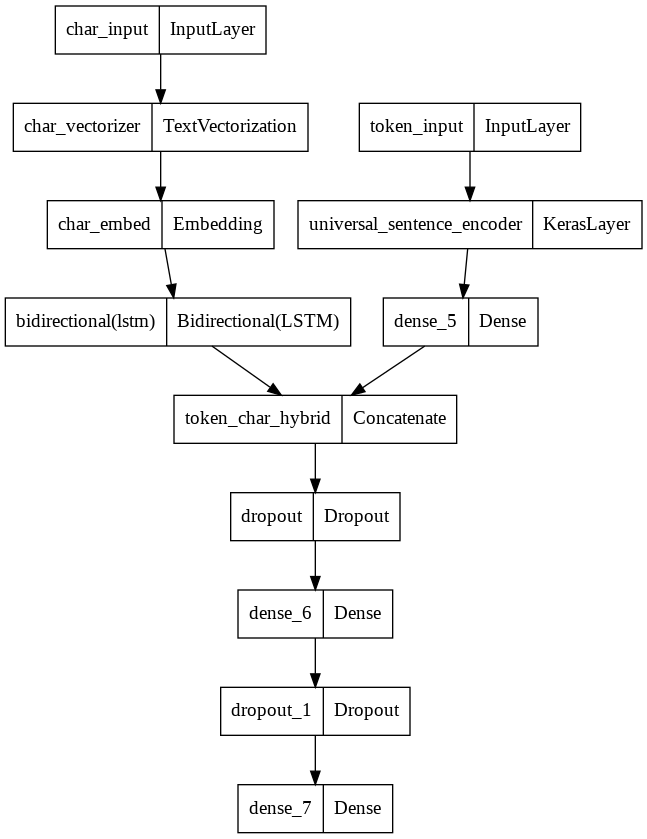

In [ ]:
# plot the hybrid model
from keras.utils import plot_model
plot_model(model_4)

In [ ]:
model_4.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])


In [ ]:
# Combine chars and tokens into a dataset
train_char_token_data = tf.data.Dataset.from_tensor_slices((train_sentences, train_chars)) # make data
train_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot) # make labels
train_char_token_dataset = tf.data.Dataset.zip((train_char_token_data, train_char_token_labels)) # combine data and labels

# Prefetch and batch train data
train_char_token_dataset = train_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE) 

# Repeat same steps validation data
val_char_token_data = tf.data.Dataset.from_tensor_slices((val_sentences, val_chars))
val_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_char_token_dataset = tf.data.Dataset.zip((val_char_token_data, val_char_token_labels))
val_char_token_dataset = val_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
# Fit the model on tokens and chars
model_4_history = model_4.fit(train_char_token_dataset, # train on dataset of token and characters
                              steps_per_epoch=int(0.1 * len(train_char_token_dataset)),
                              epochs=3,
                              validation_data=val_char_token_dataset,
                              validation_steps=int(0.1 * len(val_char_token_dataset)))
     

Epoch 1/3
562/562 [==============================] - 43s 62ms/step - loss: 0.9691 - accuracy: 0.6094 - val_loss: 0.7855 - val_accuracy: 0.6981
Epoch 2/3
562/562 [==============================] - 42s 75ms/step - loss: 0.7941 - accuracy: 0.6947 - val_loss: 0.7140 - val_accuracy: 0.7307
Epoch 3/3
562/562 [==============================] - 27s 49ms/step - loss: 0.7671 - accuracy: 0.7038 - val_loss: 0.6909 - val_accuracy: 0.7404


In [ ]:
model_4.evaluate(val_char_token_dataset)

945/945 [==============================] - 21s 22ms/step - loss: 0.6958 - accuracy: 0.7354


[0.6957684755325317, 0.7354031801223755]

Feature engineering : is introducing non implicit features to our model. For eg: data augmentation - wkt whenever you rotate, flip or zoom in on an image,
it wont change the image, hence the weights trained on the augmented data should also be similar.

In [ ]:
# Model 5: feature engineering on our transfer learning model 

# create positional embeddings

In [ ]:
# how many different line numbers are there?
train_df["line_number"].value_counts()

0     15000
1     15000
2     15000
3     15000
4     14992
5     14949
6     14758
7     14279
8     13346
9     11981
10    10041
11     7892
12     5853
13     4152
14     2835
15     1861
16     1188
17      751
18      462
19      286
20      162
21      101
22       66
23       33
24       22
25       14
26        7
27        4
28        3
29        1
30        1
Name: line_number, dtype: int64

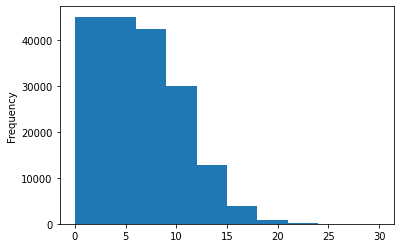

In [ ]:
#check the distribution "line number " column
train_df.line_number.plot.hist()

In [ ]:
# use tensorflow to create one-hot-encoded tensors of our "line_number" column
train_line_numbers_one_hot=tf.one_hot(train_df["line_number"].to_numpy(), depth=15)
val_line_numbers_one_hot=tf.one_hot(val_df["line_number"].to_numpy(), depth=15)
test_line_numbers_one_hot=tf.one_hot(test_df["line_number"].to_numpy(), depth=15)

train_line_numbers_one_hot[:10], train_line_numbers_one_hot.shape 


(<tf.Tensor: shape=(10, 15), dtype=float32, numpy=
 array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]],
       dtype=float32)>, TensorShape([180040, 15]))

In [ ]:
#how many different lines are there?
train_df["total_lines"].value_counts()

11    24468
10    23639
12    22113
9     19400
13    18438
14    14610
8     12285
15    10768
7      7464
16     7429
17     5202
6      3353
18     3344
19     2480
20     1281
5      1146
21      770
22      759
23      264
4       215
24      200
25      182
26       81
28       58
3        32
30       31
27       28
Name: total_lines, dtype: int64

In [ ]:
# check the coverage using percentile
np.percentile(train_df.total_lines,98)

20.0

In [ ]:
# use tensorflow to create one-hot-encoded tensors of our "total_lines" features
train_total_lines_one_hot=tf.one_hot(train_df["total_lines"].to_numpy(), depth=20)
val_total_lines_one_hot=tf.one_hot(val_df["total_lines"].to_numpy(), depth=20)
test_total_lines_one_hot=tf.one_hot(test_df["total_lines"].to_numpy(), depth=20)

train_total_lines_one_hot


<tf.Tensor: shape=(180040, 20), dtype=float32, numpy=
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)>

Create a tribrid model.
1. create a token level model.
2. create a character level number.
3. create a model for " line_number".
4. create a model for " total_lines".
5. concatenate 1. and 2. using tf.keras.layers.Concatenate
6. concatenate 3. 4. and 5
7. create an output layer to accept the tribrid embedding and output level probabilities
8. combine the inputs of 1,2,3,4 and outputs of info a tf.keras.Model


In [ ]:
#1. token inputs using functional api
token_inputs=layers.Input(shape=[],dtype=tf.string, name="token_input") #tf hub layer will take a list input hence shape=[]
token_embeddings=tf_hub_embedding_layer(token_inputs)
token_outputs= layers.Dense(128, activation="relu")(token_embeddings)
token_model= tf.keras.Model(inputs=token_inputs,
                            outputs=token_outputs)

# 2. char input model using functional api
char_inputs= layers.Input(shape=(1, ),dtype=tf.string, name="char_input")
char_vectors=char_vectorizer(char_inputs)
char_embeddings= char_embed(char_vectors)
char_bi_lstm= layers.Bidirectional(layers.LSTM(24))(char_embeddings)
char_model=tf.keras.Model(inputs=char_inputs,
                          outputs=char_bi_lstm)
# 3. create line numbers model
line_number_input=layers.Input(shape=(15, ), dtype=tf.float32)
line_number_output=layers.Dense(32,activation="relu",name="line_number_input")(line_number_input)
line_number_model= tf.keras.Model(inputs=line_number_input,
                                  outputs=line_number_output)

# 4. total lines
total_lines_input=layers.Input(shape=(20, ),dtype=tf.float32)
total_lines_output=layers.Dense(32,activation="relu", name="total_line_inputs")(total_lines_input)
total_lines_model=tf.keras.Model(inputs=total_lines_input,
                                 outputs=total_lines_output)

# 5. combine token and char embeddings
combined_embeddings= layers.Concatenate(name="token_char_hybrid_embedding")([token_model.output,
                                                                            char_model.output])
# dropout layer according to the paper
z=layers.Dense(256,activation="relu")(combined_embeddings)
z=layers.Dropout(0.5)(z)

# 6. combine the outputs of 3,4,5 
tribrid_embeddings=layers.Concatenate(name="char_token_positional_embedding")([line_number_model.output,
                                                                               total_lines_model.output,
                                                                               z])
#7 create output layer to accept tribrid model

output_layer=layers.Dense(5,activation="softmax",name="output_layer")(tribrid_embeddings)

# 8.put together the model

model_5=tf.keras.Model(inputs=[line_number_model.input,total_lines_model.input,token_model.input,char_model.input],
                       outputs=output_layer,
                       name="tribrid_embedding_model")

In [ ]:
train_line_numbers_one_hot[0].shape

TensorShape([15])

In [ ]:
model_5.summary()

Model: "tribrid_embedding_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 token_input (InputLayer)       [(None,)]            0           []                               
                                                                                                  
 char_vectorizer (TextVectoriza  (None, 290)         0           ['char_input[0][0]']             
 tion)                                                                                            
                                                                                                  
 universal_sentence_encoder (Ke  (None, 512)         256797824   ['token_inp

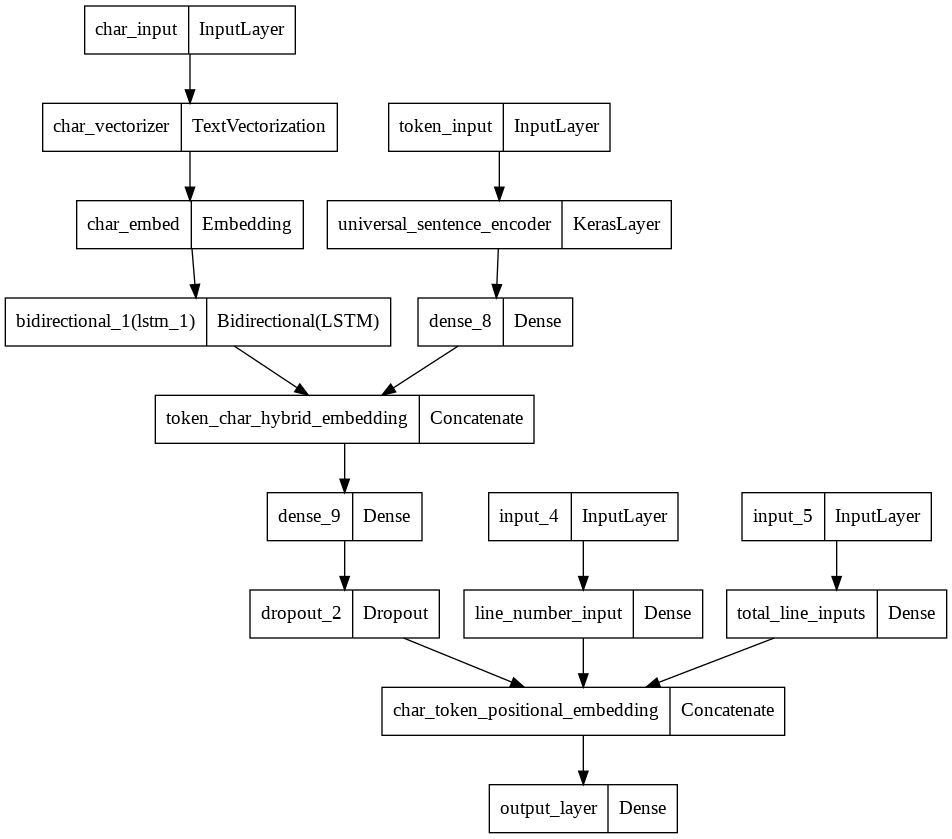

In [ ]:
plot_model(model_5)

In [ ]:
# compile the model
model_5.compile(loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

#label smoothing helps to prevent overfitting

In [ ]:
# Create tribid datasets 
# Create training and validation datasets of all 4 kinds of data

train_char_token_pos_data=tf.data.Dataset.from_tensor_slices((train_line_numbers_one_hot,
                                                       train_total_lines_one_hot,
                                                        train_sentences,
                                                        train_chars))
train_char_token_pos_labels=tf.data.Dataset.from_tensor_slices(train_labels_one_hot
                                                        )

train_char_token_pos_dataset=tf.data.Dataset.zip((train_char_token_pos_data,train_char_token_pos_labels))
train_char_token_pos_dataset=train_char_token_pos_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

#do the same for validation
 
val_char_token_pos_data=tf.data.Dataset.from_tensor_slices((val_line_numbers_one_hot,
                                                       val_total_lines_one_hot,
                                                        val_sentences,
                                                        val_chars))
val_char_token_pos_labels=tf.data.Dataset.from_tensor_slices(val_labels_one_hot
                                                        )

val_char_token_pos_dataset=tf.data.Dataset.zip((val_char_token_pos_data,val_char_token_pos_labels))
val_char_token_pos_dataset=val_char_token_pos_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
history_model_5=model_5.fit(train_char_token_pos_dataset,
                            steps_per_epoch=(0.1*len(train_char_token_pos_dataset)),
                            validation_data=val_char_token_pos_dataset,
                            validation_steps=(0.1*len(val_char_token_pos_dataset)),
                            epochs=3
                            )

Epoch 1/3
562/562 [==============================] - 39s 55ms/step - loss: 1.0951 - accuracy: 0.7270 - val_loss: 0.9891 - val_accuracy: 0.7990
Epoch 2/3
562/562 [==============================] - 34s 60ms/step - loss: 0.9669 - accuracy: 0.8145 - val_loss: 0.9488 - val_accuracy: 0.8250
Epoch 3/3
562/562 [==============================] - 25s 44ms/step - loss: 0.9499 - accuracy: 0.8235 - val_loss: 0.9348 - val_accuracy: 0.8322


In [ ]:
# make predictions 
# Make predictions with token-char-positional hybrid model
model_5_pred_probs = model_5.predict(val_char_token_pos_dataset, verbose=1)
model_5_pred_probs
     


945/945 [==============================] - 23s 22ms/step


array([[0.49560714, 0.09842126, 0.01167254, 0.37673658, 0.01756244],
       [0.54642075, 0.10271211, 0.03707648, 0.30519307, 0.00859762],
       [0.28005207, 0.1116332 , 0.10867592, 0.440832  , 0.05880671],
       ...,
       [0.03121106, 0.09637842, 0.03790107, 0.02677699, 0.80773246],
       [0.02416255, 0.31291547, 0.0952598 , 0.02140209, 0.54626006],
       [0.22686018, 0.52524436, 0.1258476 , 0.04974429, 0.07230353]],
      dtype=float32)

In [ ]:
# Turn prediction probabilities into prediction classes
model_5_preds = tf.argmax(model_5_pred_probs, axis=1)
model_5_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 4, 1])>

In [ ]:
# Calculate results of token-char-positional hybrid model
model_5_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_5_preds)
model_5_results

{'accuracy': 83.46021448431087,
 'precision': 0.8328511103531194,
 'recall': 0.8346021448431087,
 'f1': 0.8333451752907376}

In [ ]:
# Combine model results into a DataFrame
all_model_results = pd.DataFrame({"baseline": baseline_results,
                                  "custom_token_embed_conv1d": model_1.results,
                                  "pretrained_token_embed": model_2_results,
                                  "custom_char_embed_conv1d": model_3_results,
                                  # "hybrid_char_token_embed": model_4.results,
                                  "tribrid_pos_char_token_embed": model_5_results})
all_model_results = all_model_results.transpose()
all_model_results

,accuracy,precision,recall,f1
baseline,72.183238,0.718647,0.721832,0.698925
custom_token_embed_conv1d,78.587978,0.782312,0.785880,0.783262
pretrained_token_embed,71.289554,0.713340,0.712896,0.710197
custom_char_embed_conv1d,65.477294,0.646356,0.654773,0.642737
tribrid_pos_char_token_embed,83.460214,0.832851,0.834602,0.833345


In [ ]:
# saving and loading model in the savemodel format
model_5.save("skimlit_tribrid_model")


In [ ]:
# load the model that is saved
loaded_model=tf.keras.models.load_model("/content/skimlit_tribrid_model")

In [ ]:
loaded_pred_probs=loaded_model.predict(val_char_token_pos_dataset)
loaded_pred_probs

945/945 [==============================] - 29s 28ms/step


array([[0.49560714, 0.09842126, 0.01167255, 0.37673658, 0.01756244],
       [0.54642075, 0.10271211, 0.03707649, 0.30519304, 0.00859763],
       [0.2800521 , 0.11163322, 0.10867595, 0.440832  , 0.05880672],
       ...,
       [0.03121107, 0.09637842, 0.03790107, 0.02677699, 0.80773246],
       [0.02416256, 0.31291547, 0.0952598 , 0.02140209, 0.54626006],
       [0.22686017, 0.52524436, 0.1258476 , 0.04974429, 0.07230353]],
      dtype=float32)

In [ ]:
loaded_preds=tf.argmax(loaded_pred_probs,axis=1)
loaded_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 4, 1])>

In [ ]:
# calculate the resulsts of our loaded model
loaded_model_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=loaded_preds)
loaded_model_results

{'accuracy': 83.46021448431087,
 'precision': 0.8328511103531194,
 'recall': 0.8346021448431087,
 'f1': 0.8333451752907376}